In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
config = tf.compat.v1.ConfigProto(log_device_placement=True,
inter_op_parallelism_threads=0,
intra_op_parallelism_threads=0,
allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1



Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


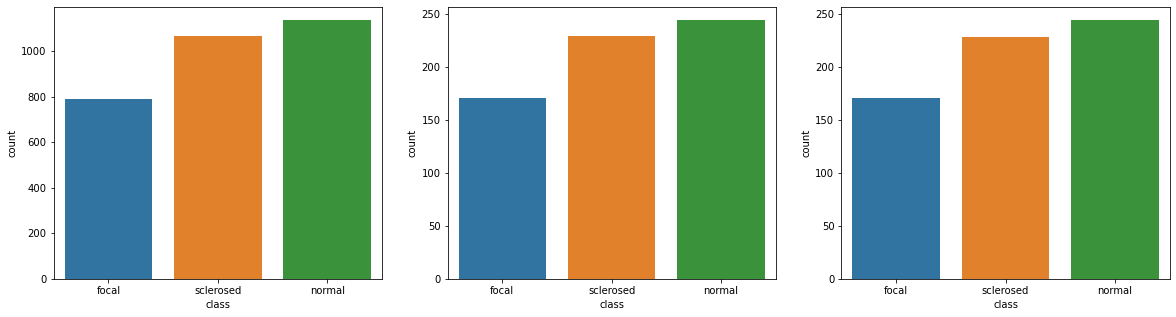

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
IMG_SIZE = 512

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

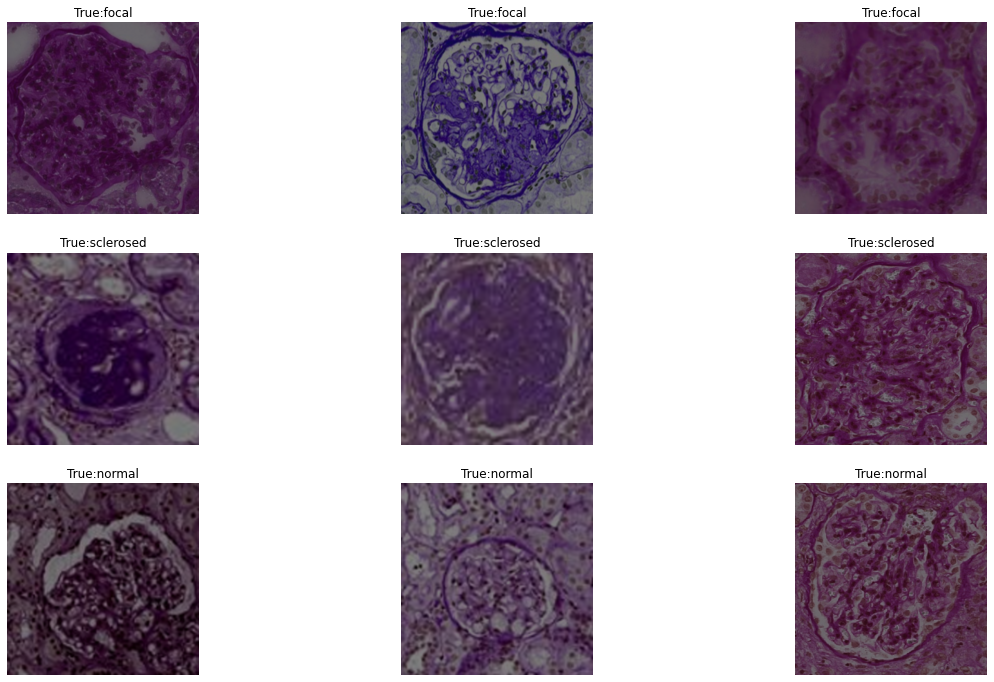

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights=None, include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(1)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
2993/2993 [==============================] - 64s 19ms/step - loss: 1.0698 - acc: 0.4045 - val_loss: 0.9344 - val_acc: 0.5047
Epoch 2/10
2993/2993 [==============================] - 62s 21ms/step - loss: 0.9269 - acc: 0.5463 - val_loss: 0.8189 - val_acc: 0.6231
Epoch 3/10
2993/2993 [==============================] - 57s 19ms/step - loss: 0.8438 - acc: 0.5702 - val_loss: 0.7575 - val_acc: 0.6246
Epoch 4/10
2993/2993 [==============================] - 61s 20ms/step - loss: 0.7730 - acc: 0.6144 - val_loss: 0.6937 - val_acc: 0.7025
Epoch 5/10
2993/2993 [==============================] - 62s 21ms/step - loss: 0.7445 - acc: 0.6569 - val_loss: 0.7376 - val_acc: 0.7181
Epoch 6/10
2993/2993 [==============================] - 56s 19ms/step - loss: 0.7279 - acc: 0.6709 - val_loss: 0.6538 - val_acc: 0.7165
Epoch 7/10
2993/2993 [==============================] - 56s 19ms/step - loss: 0.6939 - acc: 0.6806 - 

[0.695527195930481, 0.7091757655143738]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(2)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
1497/1497 [==============================] - 58s 33ms/step - loss: 0.5663 - acc: 0.7604 - val_loss: 0.5452 - val_acc: 0.7586
Epoch 2/10
1497/1497 [==============================] - 50s 34ms/step - loss: 0.5570 - acc: 0.7648 - val_loss: 0.6059 - val_acc: 0.7134
Epoch 3/10
1497/1497 [==============================] - 51s 34ms/step - loss: 0.5516 - acc: 0.7728 - val_loss: 0.6317 - val_acc: 0.7321
Epoch 4/10
1497/1497 [==============================] - 50s 34ms/step - loss: 0.5437 - acc: 0.7681 - val_loss: 0.5695 - val_acc: 0.7539
Epoch 5/10
1497/1497 [==============================] - 51s 34ms/step - loss: 0.5328 - acc: 0.7675 - val_loss: 0.6440 - val_acc: 0.7243
Epoch 6/10
1497/1497 [==============================] - 51s 34ms/step - loss: 0.5269 - acc: 0.7798 - val_loss: 0.4722 - val_acc: 0.8115
Epoch 7/10
1497/1497 [==============================] - 51s 34ms/step - loss: 0.5236 - acc: 0.7828 - 

[0.4962003827095032, 0.7978227138519287]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(4)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
749/749 [==============================] - 56s 61ms/step - loss: 0.4810 - acc: 0.7949 - val_loss: 0.4539 - val_acc: 0.8178
Epoch 2/10
749/749 [==============================] - 46s 61ms/step - loss: 0.4718 - acc: 0.8055 - val_loss: 0.4710 - val_acc: 0.8006
Epoch 3/10
749/749 [==============================] - 46s 62ms/step - loss: 0.4767 - acc: 0.7999 - val_loss: 0.4848 - val_acc: 0.8069
Epoch 4/10
749/749 [==============================] - 46s 62ms/step - loss: 0.4736 - acc: 0.7989 - val_loss: 0.4313 - val_acc: 0.8474
Epoch 5/10
749/749 [==============================] - 46s 61ms/step - loss: 0.4720 - acc: 0.8032 - val_loss: 0.4931 - val_acc: 0.7913
Epoch 6/10
749/749 [==============================] - 47s 62ms/step - loss: 0.4724 - acc: 0.7982 - val_loss: 0.4498 - val_acc: 0.8193
Epoch 7/10
749/749 [==============================] - 46s 62ms/step - loss: 0.4689 - acc: 0.7925 - val_loss: 0.40

[0.47257500886917114, 0.785381019115448]

In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(8)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
375/375 [==============================] - 56s 119ms/step - loss: 0.4355 - acc: 0.8209 - val_loss: 0.4600 - val_acc: 0.7960
Epoch 2/10
375/375 [==============================] - 45s 119ms/step - loss: 0.4403 - acc: 0.8112 - val_loss: 0.4185 - val_acc: 0.8349
Epoch 3/10
375/375 [==============================] - 46s 120ms/step - loss: 0.4373 - acc: 0.8236 - val_loss: 0.4180 - val_acc: 0.8209
Epoch 4/10
375/375 [==============================] - 45s 120ms/step - loss: 0.4473 - acc: 0.8136 - val_loss: 0.4528 - val_acc: 0.8193
Epoch 5/10
375/375 [==============================] - 45s 119ms/step - loss: 0.4367 - acc: 0.8169 - val_loss: 0.4055 - val_acc: 0.8442
Epoch 6/10
375/375 [==============================] - 45s 119ms/step - loss: 0.4328 - acc: 0.8226 - val_loss: 0.4428 - val_acc: 0.8006
Epoch 7/10
375/375 [==============================] - 45s 120ms/step - loss: 0.4332 - acc: 0.8166 - val_los

[0.49955761432647705, 0.8024883270263672]

In [16]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(16)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
188/188 [==============================] - 51s 205ms/step - loss: 0.4155 - acc: 0.8289 - val_loss: 0.4124 - val_acc: 0.8271
Epoch 2/10
188/188 [==============================] - 40s 209ms/step - loss: 0.4146 - acc: 0.8279 - val_loss: 0.3946 - val_acc: 0.8349
Epoch 3/10
188/188 [==============================] - 41s 214ms/step - loss: 0.4159 - acc: 0.8303 - val_loss: 0.4046 - val_acc: 0.8442
Epoch 4/10
188/188 [==============================] - 42s 220ms/step - loss: 0.4160 - acc: 0.8293 - val_loss: 0.4105 - val_acc: 0.8458
Epoch 5/10
188/188 [==============================] - 42s 217ms/step - loss: 0.4159 - acc: 0.8276 - val_loss: 0.3982 - val_acc: 0.8427
Epoch 6/10
188/188 [==============================] - 42s 217ms/step - loss: 0.4122 - acc: 0.8303 - val_loss: 0.3846 - val_acc: 0.8458
Epoch 7/10
188/188 [==============================] - 42s 219ms/step - loss: 0.4069 - acc: 0.8306 - val_los

[0.4332658052444458, 0.8180404305458069]

In [17]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(32)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
94/94 [==============================] - 68s 559ms/step - loss: 0.4066 - acc: 0.8273 - val_loss: 0.3954 - val_acc: 0.8489
Epoch 2/10
94/94 [==============================] - 43s 432ms/step - loss: 0.4047 - acc: 0.8329 - val_loss: 0.3753 - val_acc: 0.8536
Epoch 3/10
94/94 [==============================] - 43s 434ms/step - loss: 0.4026 - acc: 0.8319 - val_loss: 0.3846 - val_acc: 0.8396
Epoch 4/10
94/94 [==============================] - 44s 441ms/step - loss: 0.4032 - acc: 0.8339 - val_loss: 0.3881 - val_acc: 0.8411
Epoch 5/10
94/94 [==============================] - 43s 436ms/step - loss: 0.3963 - acc: 0.8403 - val_loss: 0.4064 - val_acc: 0.8255
Epoch 6/10
94/94 [==============================] - 44s 446ms/step - loss: 0.3980 - acc: 0.8336 - val_loss: 0.3824 - val_acc: 0.8458
Epoch 7/10
94/94 [==============================] - 44s 440ms/step - loss: 0.4067 - acc: 0.8299 - val_loss: 0.3884 - va

[0.4161979854106903, 0.8242612481117249]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(64)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
18/47 [==========>...................] - ETA: 17s - loss: 1.1222 - acc: 0.3630

ResourceExhaustedError:  OOM when allocating tensor with shape[64,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv2/Relu (defined at <ipython-input-12-c1a9561c6ced>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1417]

Function call stack:
train_function


In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(128)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[128,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv1/Relu (defined at <ipython-input-12-c1a9561c6ced>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1417]

Function call stack:
train_function


In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=1000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(256)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[256,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv1/Relu (defined at <ipython-input-12-c1a9561c6ced>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1417]

Function call stack:
train_function


In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(512)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[512,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv1/Relu (defined at <ipython-input-12-c1a9561c6ced>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1417]

Function call stack:
train_function


In [16]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(1024)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[945,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1417]

Function call stack:
train_function


In [17]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(2048)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10


ResourceExhaustedError:  SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;3adba5ec3d125e82;/job:localhost/replica:0/task:0/device:GPU:0;ret_0;0:0
	 [[{{node RemoteCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1417]

Function call stack:
train_function
